# ⭐🐟 GBR : Pre Processing ⭐🐟
### By [Luca Ordronneau](https://www.kaggle.com/lucaordronneau)
Data preparation notebook with an image pre-processing step (image tile). You can have a presentation of [**Image Tilling for Small Object Detection** here](https://www.kaggle.com/lucaordronneau/image-tilling-for-small-object-detection).
I decided to have **tile images for training** and **normal size images for validation**
# 📚 Import Librairies

In [1]:
import os
import ast
import random
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.pyplot import figure
from shapely.geometry import Polygon
import seaborn as sns
import shutil

# 📂 Variables and Data preparation

In [2]:
REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR  = '/kaggle/input/tensorflow-great-barrier-reef'
IMAGE_DIR = '/kaggle/images' # directory to save images
LABEL_DIR = '/kaggle/labels' # directory to save labels
SPLIT     = 2
WIDTH     = 1280
HEIGHT    = 720

In [3]:
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []

In [4]:
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))

  0%|          | 0/23501 [00:00<?, ?it/s]

In [5]:
df['nb_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.nb_bbox>0).value_counts(normalize=True)*100
print(f"No BBOX: {data[0]:0.2f}% | With BBOX: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBOX: 79.07% | With BBOX: 20.93%


In [6]:
def get_path(row):
    row['old_image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

df = df.progress_apply(get_path, axis=1)

  0%|          | 0/23501 [00:00<?, ?it/s]

In [7]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

df['bboxes'] = df.annotations.progress_apply(get_bbox)

  0%|          | 0/23501 [00:00<?, ?it/s]

In [8]:
df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   nb_bbox                                     old_image_path bboxes  
0        0  /kaggle/input/tensorflow-great-barrier-reef/tr...     []  
1        0  /kaggle/input/tensorflow-great-barrier-reef/tr...     []  
2        0  /kaggle/input/tensorflow-great-barrier-reef/tr...     []  
3        0  /kaggle/input/tensorflow-great-barrier-reef/tr...     []  
4        0  /kaggle/input/tensorflow-great-barrier-reef/tr...     []

## Implementation of a Sub Sequence strategy

In [9]:
df['has_annotations']         = df['annotations'].str.len() > 0
df['doesnt_have_annotations'] = df['annotations'].str.len() == 0

In [10]:
df['start_cut_here']  = df['has_annotations'] & df['doesnt_have_annotations'].shift(1)  & df['doesnt_have_annotations'].shift(2)
df['end_cut_here']    = df['doesnt_have_annotations'] & df['has_annotations'].shift(1)  & df['has_annotations'].shift(2)
df['sequence_change'] = df['sequence'] != df['sequence'].shift(1)
df['last_row']        =  df.index == len(df)-1
df['cut_here']        = df['start_cut_here'] | df['end_cut_here'] | df['sequence_change'] | df['last_row']

In [11]:
start_idx = 0
for subsequence_id, end_idx in enumerate(df[df['cut_here']].index):
    df.loc[start_idx:end_idx, 'subsequence_id'] = subsequence_id
    start_idx = end_idx

In [12]:
df['subsequence_id'] = df['subsequence_id'].astype(int)

In [13]:
print("NB SEQ     :",df['sequence'].nunique())
print("NB SUB SEQ :",df['subsequence_id'].nunique())

NB SEQ     : 20
NB SUB SEQ : 137


In [14]:
drop_cols = ['start_cut_here', 'end_cut_here', 'sequence_change', 'last_row', 'cut_here', 'doesnt_have_annotations']
df = df.drop(drop_cols, axis=1)

# 📌 Help functions

In [15]:
def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y2]
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes[..., 2:4] -= bboxes[..., 0:2]
    return bboxes

def coco2voc(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    voc  => [x1, y1, x2, y2]
    
    """ 
    bboxes[..., 2:4] += bboxes[..., 0:2]
    return bboxes

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y2]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def clip_bbox(bboxes_voc, image_height=720, image_width=1280):
    """Clip bounding boxes to image boundaries.
    Args:
        bboxes_voc (np.ndarray): bboxes in [xmin, ymin, xmax, ymax] format.
        height (int, optional): height of bbox. Defaults to 720.
        width (int, optional): width of bbox. Defaults to 1280.
    Returns:
        np.ndarray : clipped bboxes in [xmin, ymin, xmax, ymax] format.
    """
    bboxes_voc[..., 0::2] = np.clip(bboxes_voc[..., 0::2], 0, image_width)
    bboxes_voc[..., 1::2] = np.clip(bboxes_voc[..., 1::2], 0, image_height)
    return bboxes_voc

In [16]:
def plot_image_and_bboxes(img, bboxes):
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(img)
    
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor="none")
        ax.add_patch(rect)
    
    plt.show()

In [17]:
def get_image(img_name):
    return np.array(Image.open(img_name))

# 🔨 Functions to build tiles of an image

In [18]:
def image_tiler(img, s_h=180, s_w=320):
    tiles = [img[x:x+s_h,y:y+s_w] for x in range(0,img.shape[0],s_h) for y in range(0,img.shape[1],s_w)]
    return tiles

In [19]:
def tiler_plot(img_name, img_paths_bboxes_dict, s_h = 180, s_w = 320, height = 720, width = 1280):
    basename = os.path.basename(os.path.splitext(img_name)[0])
    bboxes = img_paths_bboxes_dict[img_name][0]
    
    tiles_dict = {}
    boxes = []
    
    plt.gca().invert_yaxis()
    
    for bbox in bboxes:
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0] + bbox[2]
        y2 = bbox[1] + bbox[3]
        boxes.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
      
    for i in range((height // s_h)):
        for j in range((width // s_w)):
            
            x1 = j*s_w
            y1 = height - (i*s_h)
            x2 = ((j+1)*s_w)
            y2 = (height - (i+1)*s_h)
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            
            slice_labels = []
            plt.plot(*pol.exterior.xy)
            for box in boxes:
                if pol.intersects(box):
                    inter = pol.intersection(box)                        
                    new_box = inter.envelope 
                    plt.scatter(new_box.centroid.x, new_box.centroid.y)
                    plt.plot(*new_box.exterior.coords.xy)

In [20]:
def tiler(img_name, img_paths_bboxes_dict, s_h = 180, s_w = 320, height = 720, width = 1280):
    basename   = os.path.basename(os.path.splitext(img_name)[0])
    bboxes     = img_paths_bboxes_dict[img_name][0]
    tiles_dict = {}
    boxes      = []

    for bbox in bboxes:
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0] + bbox[2]
        y2 = bbox[1] + bbox[3]
        boxes.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
    for i in range(int(height // s_h)):
        for j in range(int(width // s_w)):
            
            x1 = j*s_w
            y1 = height - (i*s_h)
            x2 = ((j+1)*s_w)
            y2 = (height - (i+1)*s_h)
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            
            slice_labels = []
            
            for box in boxes:
                if pol.intersects(box):
                    inter = pol.intersection(box)                        
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    new_width  = (max(x) - min(x))
                    new_height = (max(y) - min(y))
                    
                    # Get new_x min and new_y min
                    new_x = (min(x) - x1)
                    new_y = (min(y) - y2)
                    
                    # Remove small bbox (unsignificant)
                    if ((new_width > 15) and (new_height > 15)):
                        slice_labels.append([new_x, new_y, new_width, new_height])
            tiles_dict[basename + "-" + str(SPLIT-i-1)+"-"+str(j)] = slice_labels
    return dict(sorted(tiles_dict.items()))

In [21]:
def keep_bboxes_tiles(tiles, tiles_dict):
    bboxes_tiles = {}
    tiles_keys = [*tiles_dict]
    for k, v in tiles_dict.items():
        if len(v):
            tile_index = tiles_keys.index(k)
            bboxes_tiles[k] = np.array([tiles[tile_index], np.array(v)], dtype=object)
    return bboxes_tiles

In [22]:
!mkdir ./images
!mkdir ./labels

# 🧮 Sub Sequence split strategy

In [23]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [24]:
df_split = df.groupby("subsequence_id").agg({'has_annotations': 'max', 'video_frame': 'count'}).astype(int).reset_index()

In [25]:
df_train_idx, df_val_idx = train_test_split(df_split['subsequence_id'], stratify=df_split["has_annotations"], test_size=0.15, random_state=42)
df['is_train']   = df['subsequence_id'].isin(df_train_idx)
df_train, df_val = df[df['is_train']], df[~df['is_train']]

In [26]:
if REMOVE_NOBBOX:
    valid_df = df_val.query("nb_bbox>0")

if REMOVE_NOBBOX:
    train_df = df_train.query("nb_bbox>0")

In [27]:
def preprocess_img(img):
    return tfa.image.equalize(img)

In [28]:
train_files = []
val_files   = []

val_files   += list(valid_df["old_image_path"].unique())
len(val_files)

606

# 💾 Save normal size images for validation

In [29]:
def save_valid_images(valid_files, valid_bboxes, valid_img_id):
    new_valid_files = []
    
    for f in valid_files:
        idx    = valid_files.index(f)
        bboxes = np.array(valid_bboxes[idx]).astype(np.float32).copy()
        img_id = valid_img_id[idx]
        
        new_img_name = f"/kaggle/working/images/{img_id}.jpg"
        
        new_valid_files.append(new_img_name)
        
        # Without Preprocessing
        shutil.copyfile(f, new_img_name)
        
        # Preprocessing
#         img         = preprocess_img(get_image(f))
#         img_to_save = Image.fromarray(img.numpy())
#         img_to_save.save(new_img_name)
        
        bboxes_voc  = coco2voc(bboxes)
        bboxes_voc  = clip_bbox(bboxes_voc)
        bboxes_yolo = voc2yolo(bboxes_voc)
    
        bboxes_yolo_str = [" ".join(item) for item in bboxes_yolo.astype(str)]
        bboxes_yolo_str = list(map(lambda x: "0 " + x, bboxes_yolo_str))
        
        new_label_name = f"/kaggle/working/labels/{img_id}.txt"
        with open(new_label_name, 'w') as f:
            f.write('\n'.join(bboxes_yolo_str))
        
    return new_valid_files

In [30]:
valid_img_id = valid_df["image_id"].tolist()
valid_files  = valid_df['old_image_path'].tolist()
valid_bboxes = valid_df['bboxes'].tolist()

new_valid_files = save_valid_images(valid_files, valid_bboxes, valid_img_id)

# 💾 Save tiles images for training

In [31]:
old_image_path = train_df['old_image_path'].tolist()
bboxes         = train_df['bboxes'].tolist()
video_id       = train_df['video_id'].tolist()
sequence       = train_df['sequence'].tolist()
sub_sequence   = train_df['subsequence_id'].tolist()

values = list(zip(bboxes, video_id, sequence, sub_sequence))

img_paths_bboxes      = list(zip(old_image_path, values))
img_paths_bboxes_dict = dict(img_paths_bboxes)

{'9004-0-0': [[432.0, 137.0, 34.0, 27.0]], '9004-0-1': [], '9004-1-0': [], '9004-1-1': []}


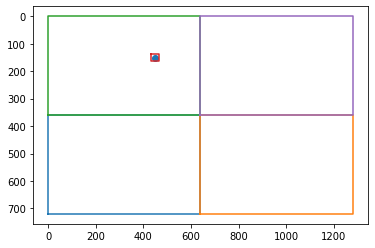

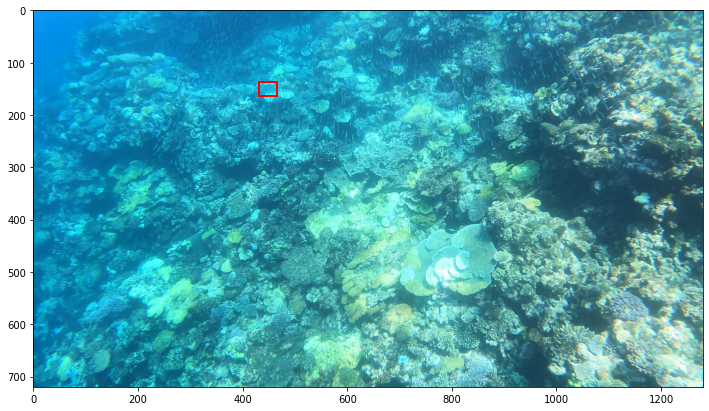

BBOXES 9004-0-0 [[432. 137.  34.  27.]]


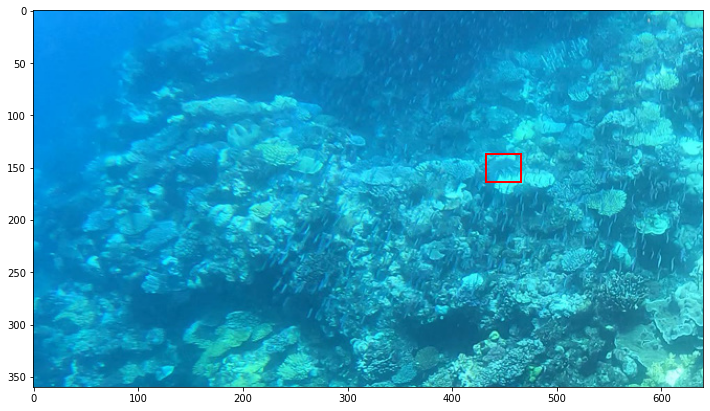

In [32]:
img_name   = random.choice(img_paths_bboxes)[0]

tiles_dict = tiler(img_name, img_paths_bboxes_dict, s_h = int(HEIGHT//SPLIT), s_w = int(WIDTH//SPLIT))
print(tiles_dict)
tiler_plot(img_name, img_paths_bboxes_dict, s_h = int(HEIGHT//SPLIT), s_w = int(WIDTH//SPLIT))

img    = get_image(img_name)
bboxes = img_paths_bboxes_dict[img_name][0]
plot_image_and_bboxes(img, bboxes)

tiles   = image_tiler(img, s_h = int(HEIGHT//SPLIT), s_w = int(WIDTH//SPLIT))
to_save = keep_bboxes_tiles(tiles, tiles_dict)
for k, v in to_save.items():
    print("BBOXES", k, v[1])
    plot_image_and_bboxes(v[0], v[1])

In [33]:
def tiles_to_save(img_paths_bboxes, height=180, width=320):
    img_paths_bboxes_dict = dict(img_paths_bboxes)
    
    all_video_id          = []
    all_sequences         = []
    all_sub_sequences     = []
    all_base_img          = []
    all_label_files_names = []
    all_img_files_names   = []
    
    for img_path_bbox in img_paths_bboxes:
        img_name     = img_path_bbox[0]
        tiles_dict   = tiler(img_name, img_paths_bboxes_dict, s_h = int(HEIGHT//SPLIT), s_w = int(WIDTH//SPLIT))
        video_id     = img_path_bbox[1][1]
        sequence     = img_path_bbox[1][2]
        sub_sequence = img_path_bbox[1][3]
        
        img   = get_image(img_name)
        
        # tiles = image_tiler(preprocess_img(img), s_h = int(HEIGHT//SPLIT), s_w = int(WIDTH//SPLIT)) # preprocess image
        tiles = image_tiler(img, s_h = int(HEIGHT//SPLIT), s_w = int(WIDTH//SPLIT))
        
        to_save = keep_bboxes_tiles(tiles, tiles_dict)
        for k, v in to_save.items():
            tile_img_name = str(video_id) + "-" + k
            tile_img      = np.copy(v[0])
            # tile_img      = np.copy(v[0].numpy())
            tile_bboxes   = np.copy(v[1])
            
            label_file_name = os.path.join("/kaggle/working/labels", tile_img_name + ".txt")
            img_file_name   = os.path.join("/kaggle/working/images", tile_img_name + ".jpg")
            
            all_base_img.append(img_name)
            all_video_id.append(video_id)
            all_sequences.append(sequence)
            all_label_files_names.append(label_file_name)
            all_img_files_names.append(img_file_name)
            all_sub_sequences.append(sub_sequence)
            
            bboxes_voc  = coco2voc(tile_bboxes, image_height=height, image_width=width)
            bboxes_voc  = clip_bbox(bboxes_voc, image_height=height, image_width=width)
            bboxes_yolo = voc2yolo(bboxes_voc, image_height=height, image_width=width)
  
            bboxes_yolo_str = [" ".join(item) for item in bboxes_yolo.astype(str)]
            bboxes_yolo_str =  list(map(lambda x: "0 " + x, bboxes_yolo_str))
            
            with open(label_file_name, 'w') as f:
                f.write('\n'.join(bboxes_yolo_str))
                
            tile_img_to_save = Image.fromarray(tile_img)
            tile_img_to_save.save(img_file_name)
            
    return all_video_id, all_sequences, all_sub_sequences, all_base_img, all_img_files_names, all_label_files_names #, all_tile_img_to_save, all_bboxes_yolo_str

In [34]:
all_video_id, all_sequences, all_sub_sequences, all_base_img, all_img_files_names, all_label_files_names = tiles_to_save(img_paths_bboxes, height =  int(HEIGHT//SPLIT), width = int(WIDTH//SPLIT))

In [35]:
starfish_list = list(zip(all_video_id, all_sequences, all_sub_sequences, all_base_img, all_img_files_names, all_label_files_names))
starfish_df   = pd.DataFrame(starfish_list, columns=['video_id', 'sequence', 'sub_sequence_id', 'img_name','tile_img_name', 'tile_label_name'])

In [36]:
starfish_df.head()

video_id  sequence  sub_sequence_id  \
0         0     40258                2   
1         0     40258                2   
2         0     40258                2   
3         0     40258                2   
4         0     40258                2   

                                            img_name  \
0  /kaggle/input/tensorflow-great-barrier-reef/tr...   
1  /kaggle/input/tensorflow-great-barrier-reef/tr...   
2  /kaggle/input/tensorflow-great-barrier-reef/tr...   
3  /kaggle/input/tensorflow-great-barrier-reef/tr...   
4  /kaggle/input/tensorflow-great-barrier-reef/tr...   

                         tile_img_name                      tile_label_name  
0  /kaggle/working/images/0-16-0-0.jpg  /kaggle/working/labels/0-16-0-0.txt  
1  /kaggle/working/images/0-17-0-0.jpg  /kaggle/working/labels/0-17-0-0.txt  
2  /kaggle/working/images/0-18-0-0.jpg  /kaggle/working/labels/0-18-0-0.txt  
3  /kaggle/working/images/0-19-0-0.jpg  /kaggle/working/labels/0-19-0-0.txt  
4  /kaggle/working/images/0-20-0-0.jpg  /kaggle/working/labels/0-20-0-0.txt

In [37]:
train_files += list(starfish_df["tile_img_name"].unique())

len(train_files)

6294

In [38]:
len(train_files), len(val_files)

(6294, 606)

In [39]:
print("Train", 100 * len(train_files)/(len(train_files)+len(val_files)))
print("Valid", 100 * len(val_files)/(len(train_files)+len(val_files)))

Train 91.21739130434783
Valid 8.782608695652174


# ⚙️ Create configuration file for YOLOv5

In [40]:
import yaml

cwd = '/kaggle/working/'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_files:
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in new_valid_files:
        f.write(path+'\n')

data = dict(
    path  = '/kaggle/working',
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['starfish'],
    )

with open(os.path.join( cwd , 'data.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

# ✨ Display some images

In [41]:
def plot_image_an_bboxes_yolo(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline="#ff8300", width=1)
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.figure(figsize = (12,10))
    plt.imshow(np.array(image))
    plt.show()

In [42]:
images = sorted([os.path.join("/kaggle/working/images", x) for x in os.listdir("/kaggle/working/images")])
labels = sorted([os.path.join("/kaggle/working/labels", x) for x in os.listdir("/kaggle/working/labels")])

In [43]:
cl = "starfish"
class_id_to_name_mapping = {0 : cl}
class_id_to_name_mapping

{0: 'starfish'}

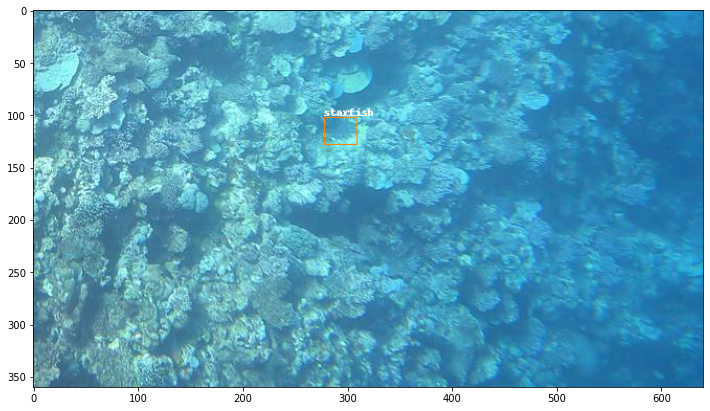

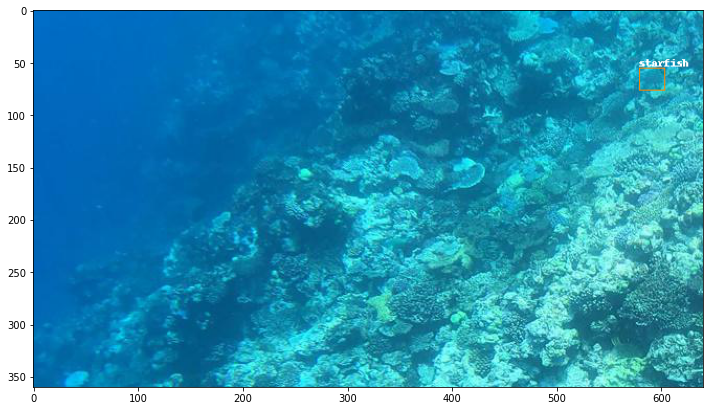

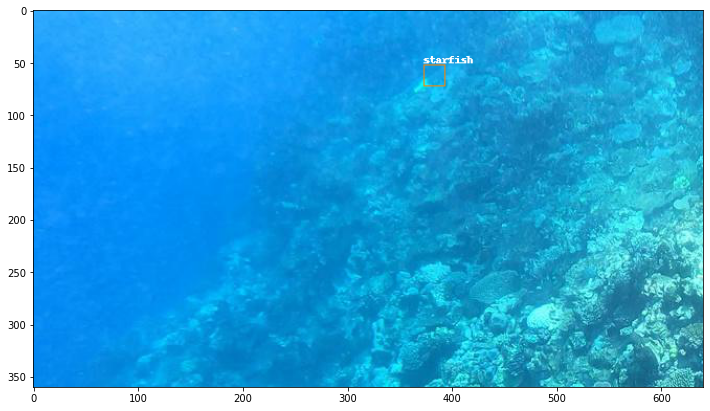

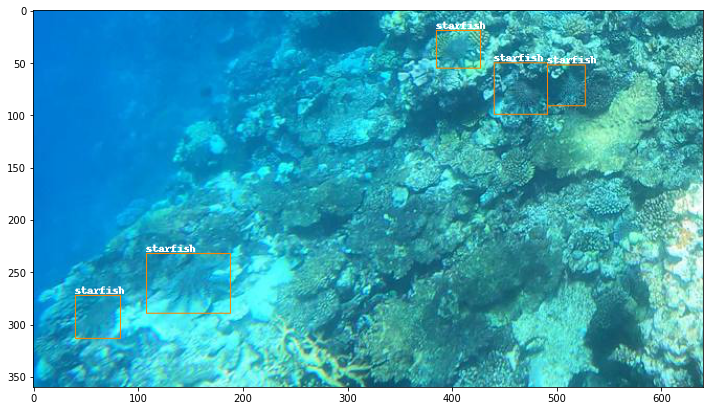

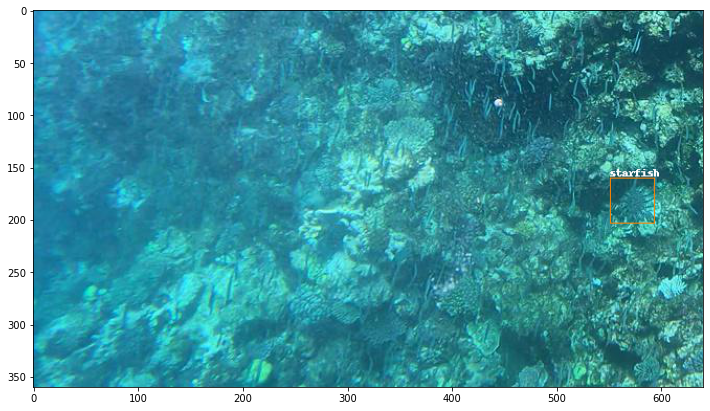

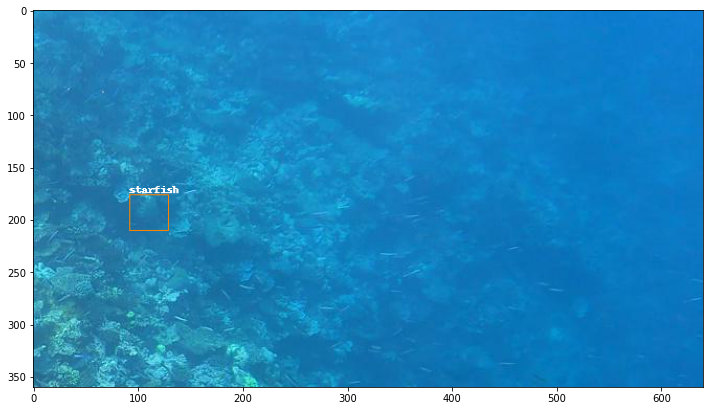

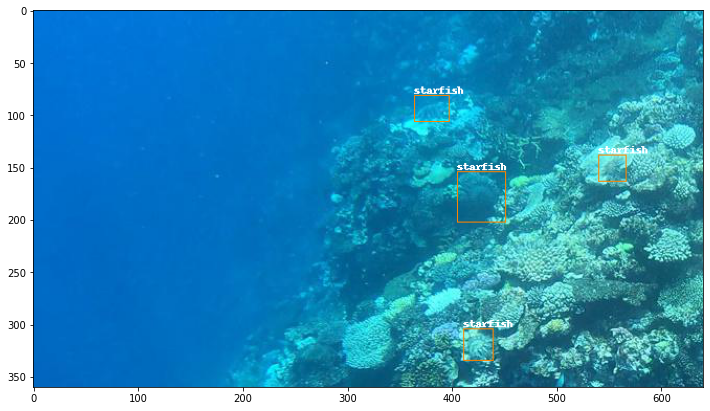

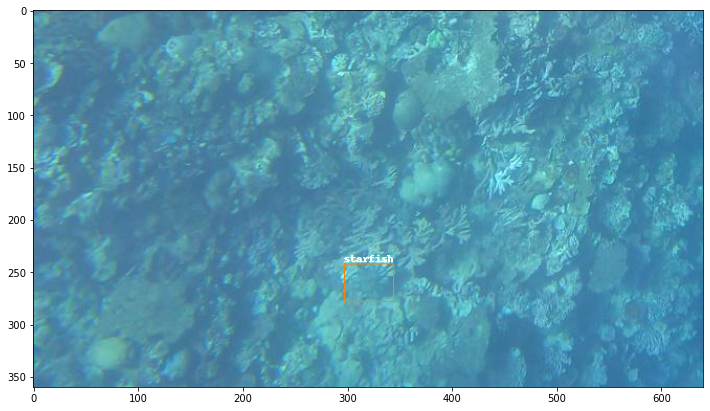

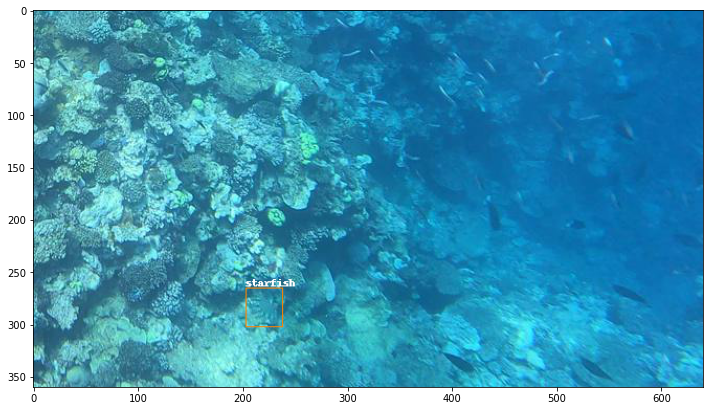

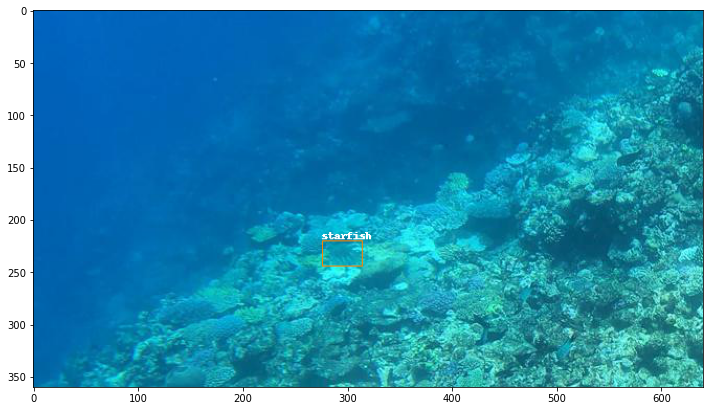

In [44]:
for i in range(10):
    # Get any random annotation file 
    label_file = random.choice(labels)
    with open(label_file, "r") as file:
        label_list = file.read().split("\n")
        label_list = [x.split(" ") for x in label_list]
        label_list = [[float(y) for y in x ] for x in label_list]

    #Get the corresponding image file
    image_file = os.path.basename(label_file.replace(".txt", ".jpg"))
    image = Image.open("./images/" + image_file)
    plot_image_an_bboxes_yolo(image, label_list)